In [ ]:
!nvidia-smi

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
device = torch.device("cuda:3")

In [2]:
#!git clone https://github.com/pacifinapacific/StyleGAN_LatentEditor

In [3]:
import json
from urllib.request import urlretrieve
import pickle
from urllib.request import urlopen

''' 급 오류남
import requests
r = requests.get('http://www.anishathalye.com/media/2017/07/25/imagenet.json')
print(r.content)
이미지넷(ImageNet)에 정의된 1,000개의 레이블(클래스) 정보 가져오기
imagenet_json, _ = urlretrieve('http://www.anishathalye.com/media/2017/07/25/imagenet.json')
with open(imagenet_json) as f:
   imagenet_labels = json.load(f)
print(imagenet_labels[18])
'''

imagenet_labels= pickle.load(urlopen('https://gist.githubusercontent.com/yrevar/6135f1bd8dcf2e0cc683/raw/d133d61a09d7e5a3b36b8c111a8dd5c4b5d560ee/imagenet1000_clsid_to_human.pkl')) 
print(imagenet_labels[18])
imagenet_labels = list(imagenet_labels.values())
print(imagenet_labels[18] )


magpie


In [4]:
import matplotlib.pyplot as plt
import PIL

imsize = 256

preprocess = transforms.Compose([
    transforms.Resize(imsize),
    transforms.CenterCrop(imsize), 
    transforms.ToTensor(), 
])

def image_loader(path):
    image = PIL.Image.open(path)
    image = preprocess(image).unsqueeze(0) #베치 차원
    return image.to(device, torch.float) # raw한 이미지 GPU로 올릴때 float로 올려주기 

#image= image_loader('./cat2.jpg')

def imshow(tensor):
    # matplotlib는 CPU 기반이므로 CPU로 옮기기 기억하기
    image = tensor.cpu().clone()
    image = image.squeeze(0) #배치차원 제거
    # PIL 객체로 변경 
    image = transforms.ToPILImage()(image) #토치 transform기능중 PIL로 변경
    # 이미지를 화면에 출력(matplotlib는 [0, 1] 사이의 값이라고 해도 정상적으로 처리)
    plt.imshow(image)
# plt.figure()
# imshow(image)

In [5]:
class Normalize(nn.Module) :
    def __init__(self, mean, std) :
        super(Normalize, self).__init__()
        self.register_buffer('mean', torch.Tensor(mean))
        self.register_buffer('std', torch.Tensor(std))
        
    def forward(self, input):
        mean = self.mean.reshape(1, 3, 1, 1)
        std = self.std.reshape(1, 3, 1, 1)
        return (input - mean) / std

classifier = nn.Sequential(
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  #Inception v3 의 정규화
    torch.hub.load('pytorch/vision:v0.6.0', 'inception_v3', pretrained=True)
).to(device).eval() 

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


In [6]:
!pwd
%cd ./StyleGAN_LatentEditor/
!pwd

/workspace/StyleGAN_adver실험
/workspace/StyleGAN_adver실험/StyleGAN_LatentEditor
/workspace/StyleGAN_adver실험/StyleGAN_LatentEditor


In [16]:
from stylegan_layers import G_mapping, G_synthesis
from collections import OrderedDict

g_all = nn.Sequential(OrderedDict([
    ('g_mapping', G_mapping()),
    ('g_synthesis', G_synthesis(resolution=256))  
]))

g_all.load_state_dict(torch.load("karras2019stylegan-cats-256x256.pt", map_location=device))
g_all.eval()
g_all.to(device)

g_mapping, generator = g_all[0], g_all[1]
#generator.use_noise = False


512 512 True True False True True LeakyReLU(negative_slope=0.2)


In [17]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x

In [18]:
# generator.blocks["4x4"].epi1.top_epi.noise = Identity()
# generator.blocks["4x4"].epi2.top_epi.noise = Identity()
# generator.blocks["8x8"].epi1.top_epi.noise = Identity()
# generator.blocks["8x8"].epi2.top_epi.noise = Identity()
generator.blocks["16x16"].epi1.top_epi.noise = Identity()
generator.blocks["16x16"].epi2.top_epi.noise = Identity()
generator.blocks["32x32"].epi1.top_epi.noise = Identity()
generator.blocks["32x32"].epi2.top_epi.noise = Identity()
generator.blocks["64x64"].epi1.top_epi.noise = Identity()
generator.blocks["64x64"].epi2.top_epi.noise = Identity()
generator.blocks["128x128"].epi1.top_epi.noise = Identity()
generator.blocks["128x128"].epi2.top_epi.noise = Identity()
generator.blocks["256x256"].epi1.top_epi.noise = Identity()
generator.blocks["256x256"].epi2.top_epi.noise = Identity()

In [19]:
generator

G_synthesis(
  (torgb): MyConv2d()
  (blocks): ModuleDict(
    (4x4): InputBlock(
      (epi1): LayerEpilogue(
        (top_epi): Sequential(
          (noise): NoiseLayer()
          (activation): LeakyReLU(negative_slope=0.2)
          (instance_norm): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        )
        (style_mod): StyleMod(
          (lin): MyLinear()
        )
      )
      (conv): MyConv2d()
      (epi2): LayerEpilogue(
        (top_epi): Sequential(
          (noise): NoiseLayer()
          (activation): LeakyReLU(negative_slope=0.2)
          (instance_norm): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        )
        (style_mod): StyleMod(
          (lin): MyLinear()
        )
      )
    )
    (8x8): GSynthesisBlock(
      (conv0_up): MyConv2d(
        (upscale): Upscale2d()
        (intermediate): BlurLayer()
      )
      (epi1): LayerEpilogue(
        (top_epi): Sequential(
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


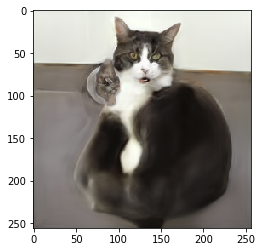

In [20]:
latent = torch.zeros((1, 18, 512), requires_grad=True, device=device)
#latent= torch.randn_like(latent,requires_grad=True,device=device)
synth_img = generator(latent)

plt.imshow( ( (synth_img + 1.0) / 2.0)[0].detach().cpu().squeeze(0).permute(1, 2, 0))
plt.show()

In [21]:
import torch.optim as optim

def unrestricted_attack(generator, classifier, ori_label, trg_label, eps, alpha, iters):
    trg_label = trg_label.to(device)
    attack_success_list=[]
    latent = torch.zeros((1, 18, 512), requires_grad=True, device=device)
    perturbation = torch.empty_like(latent).uniform_(-eps, eps)
    perturbation.to(device)

    attack_loss = nn.CrossEntropyLoss() # 타겟티드 어택으로 목표 클래스로 분류되도록
    mse = torch.nn.MSELoss(reduction='sum') # 초기 이미지와 유사하도록 , 출력값 다 더함

    # 시작 당시의 이미지 정보
    start_generated = generator(latent)

    print("[ 현재 이미지 ]")
    plt.imshow(((start_generated + 1.0) / 2.0)[0].detach().cpu().squeeze(0).permute(1, 2, 0))
    plt.show()

    for i in range(iters):
        perturbation.requires_grad = True
        now = latent + perturbation

        generator.zero_grad()
        classifier.zero_grad()

        generated = generator(now)
        outputs = classifier((generated + 1.0) / 2.0)

        if i % 20 == 0:
            print(f"[ i = {i} ]")
            print("[ 현재 이미지 ]")
            plt.imshow(((generated + 1.0) / 2.0)[0].detach().cpu().squeeze(0).permute(1, 2, 0))
            plt.show()
            percentages = torch.nn.functional.softmax(outputs, dim=1)[0] * 100
            print("< 가장 높은 확률을 가지는 클래스들 >")
            for i in outputs[0].topk(3)[1]:
                print(f"인덱스: {i.item()} / 클래스명: {imagenet_labels[i]} / 확률: {round(percentages[i].item(), 4)}%")

        percentages = torch.nn.functional.softmax(outputs, dim=1)[0] * 100
        if outputs[0].topk(1)[1] == 18 and round(percentages[18].item(), 4)>=90. :
            attack_success_list.append(f'{i} 번째 :,{round(percentages[18].item(), 4)}% 로 성공' )
                
        cost = attack_loss(outputs, trg_label).to(device) * 1e3 #1000을곱함
        cost += mse(generated, start_generated).to(device) #현재 입력과 만들어진 입력간의 mse 
        cost.backward(retain_graph=True) # 시작 이미지에 대한 기울기 정보는 유지(retain)될 수 있도록

        # 계산된 기울기(gradient)를 이용하여 손실 함수가 감소하는 방향으로 업데이트
        diff = - alpha * perturbation.grad.sign()
        perturbation = torch.clamp(perturbation + diff, min=-eps, max=eps).detach_()

    return latent, perturbation,attack_success_list

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 현재 이미지 ]


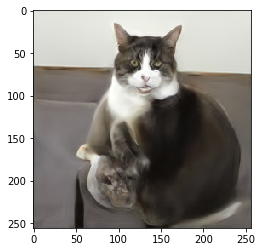

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ i = 0 ]
[ 현재 이미지 ]


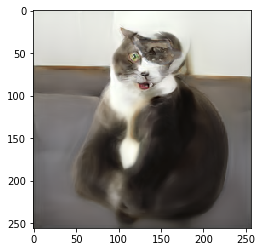

< 가장 높은 확률을 가지는 클래스들 >
인덱스: 285 / 클래스명: Egyptian cat / 확률: 59.2554%
인덱스: 281 / 클래스명: tabby, tabby cat / 확률: 36.2743%
인덱스: 282 / 클래스명: tiger cat / 확률: 3.8097%
[ i = 20 ]
[ 현재 이미지 ]


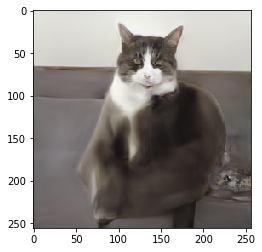

< 가장 높은 확률을 가지는 클래스들 >
인덱스: 281 / 클래스명: tabby, tabby cat / 확률: 50.2258%
인덱스: 285 / 클래스명: Egyptian cat / 확률: 36.6211%
인덱스: 282 / 클래스명: tiger cat / 확률: 11.3773%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ i = 40 ]
[ 현재 이미지 ]


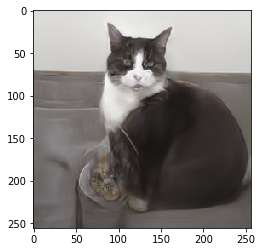

< 가장 높은 확률을 가지는 클래스들 >
인덱스: 285 / 클래스명: Egyptian cat / 확률: 44.2114%
인덱스: 469 / 클래스명: caldron, cauldron / 확률: 14.2415%
인덱스: 281 / 클래스명: tabby, tabby cat / 확률: 12.6861%
[ i = 60 ]
[ 현재 이미지 ]


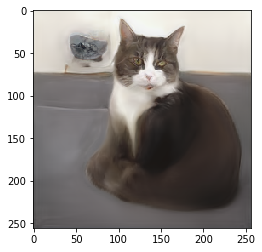

< 가장 높은 확률을 가지는 클래스들 >
인덱스: 281 / 클래스명: tabby, tabby cat / 확률: 60.932%
인덱스: 282 / 클래스명: tiger cat / 확률: 21.5281%
인덱스: 285 / 클래스명: Egyptian cat / 확률: 2.6591%
[ i = 80 ]
[ 현재 이미지 ]


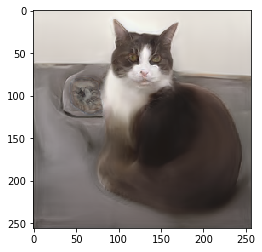

< 가장 높은 확률을 가지는 클래스들 >
인덱스: 285 / 클래스명: Egyptian cat / 확률: 57.1269%
인덱스: 281 / 클래스명: tabby, tabby cat / 확률: 20.6814%
인덱스: 284 / 클래스명: Siamese cat, Siamese / 확률: 6.9312%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ i = 100 ]
[ 현재 이미지 ]


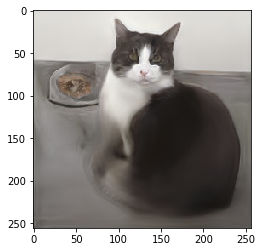

< 가장 높은 확률을 가지는 클래스들 >
인덱스: 281 / 클래스명: tabby, tabby cat / 확률: 47.3352%
인덱스: 285 / 클래스명: Egyptian cat / 확률: 30.0573%
인덱스: 282 / 클래스명: tiger cat / 확률: 4.3025%
[ i = 120 ]
[ 현재 이미지 ]


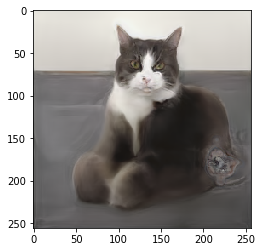

< 가장 높은 확률을 가지는 클래스들 >
인덱스: 285 / 클래스명: Egyptian cat / 확률: 42.0235%
인덱스: 281 / 클래스명: tabby, tabby cat / 확률: 25.4184%
인덱스: 282 / 클래스명: tiger cat / 확률: 8.2251%
[ i = 140 ]
[ 현재 이미지 ]


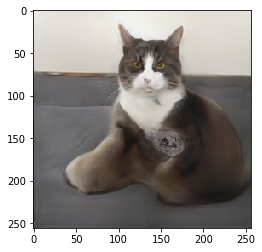

< 가장 높은 확률을 가지는 클래스들 >
인덱스: 281 / 클래스명: tabby, tabby cat / 확률: 47.9816%
인덱스: 285 / 클래스명: Egyptian cat / 확률: 20.2616%
인덱스: 282 / 클래스명: tiger cat / 확률: 10.3327%
[ i = 160 ]
[ 현재 이미지 ]


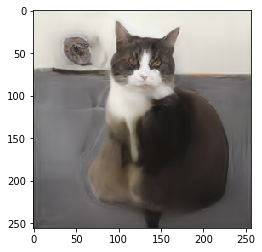

< 가장 높은 확률을 가지는 클래스들 >
인덱스: 285 / 클래스명: Egyptian cat / 확률: 29.1395%
인덱스: 284 / 클래스명: Siamese cat, Siamese / 확률: 24.5118%
인덱스: 281 / 클래스명: tabby, tabby cat / 확률: 4.8878%
[ i = 180 ]
[ 현재 이미지 ]


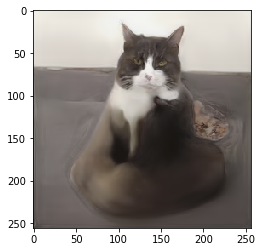

< 가장 높은 확률을 가지는 클래스들 >
인덱스: 285 / 클래스명: Egyptian cat / 확률: 36.0777%
인덱스: 281 / 클래스명: tabby, tabby cat / 확률: 23.4369%
인덱스: 284 / 클래스명: Siamese cat, Siamese / 확률: 6.3074%
[ i = 200 ]
[ 현재 이미지 ]


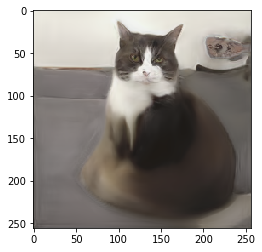

< 가장 높은 확률을 가지는 클래스들 >
인덱스: 940 / 클래스명: spaghetti squash / 확률: 43.3755%
인덱스: 942 / 클래스명: butternut squash / 확률: 19.3622%
인덱스: 941 / 클래스명: acorn squash / 확률: 6.7097%
[ i = 220 ]
[ 현재 이미지 ]


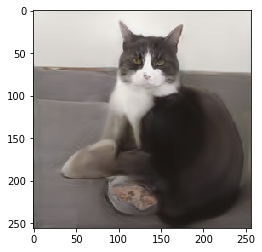

< 가장 높은 확률을 가지는 클래스들 >
인덱스: 939 / 클래스명: zucchini, courgette / 확률: 34.6127%
인덱스: 940 / 클래스명: spaghetti squash / 확률: 12.9781%
인덱스: 285 / 클래스명: Egyptian cat / 확률: 9.9001%
[ i = 240 ]
[ 현재 이미지 ]


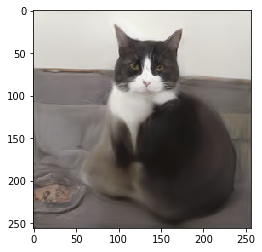

< 가장 높은 확률을 가지는 클래스들 >
인덱스: 281 / 클래스명: tabby, tabby cat / 확률: 20.4764%
인덱스: 285 / 클래스명: Egyptian cat / 확률: 14.532%
인덱스: 725 / 클래스명: pitcher, ewer / 확률: 6.8647%
[ i = 260 ]
[ 현재 이미지 ]


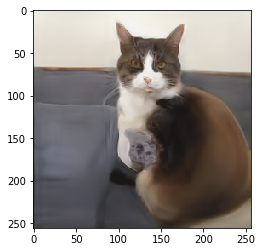

< 가장 높은 확률을 가지는 클래스들 >
인덱스: 285 / 클래스명: Egyptian cat / 확률: 28.147%
인덱스: 281 / 클래스명: tabby, tabby cat / 확률: 25.495%
인덱스: 338 / 클래스명: guinea pig, Cavia cobaya / 확률: 18.3952%
[ i = 280 ]
[ 현재 이미지 ]


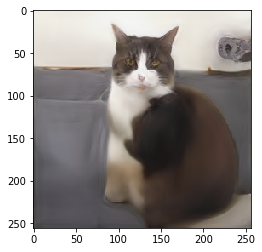

< 가장 높은 확률을 가지는 클래스들 >
인덱스: 728 / 클래스명: plastic bag / 확률: 29.33%
인덱스: 412 / 클래스명: ashcan, trash can, garbage can, wastebin, ash bin, ash-bin, ashbin, dustbin, trash barrel, trash bin / 확률: 14.0489%
인덱스: 940 / 클래스명: spaghetti squash / 확률: 6.5438%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ i = 300 ]
[ 현재 이미지 ]


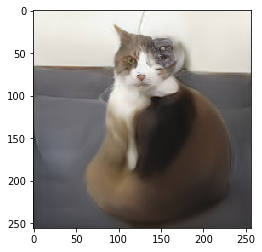

< 가장 높은 확률을 가지는 클래스들 >
인덱스: 285 / 클래스명: Egyptian cat / 확률: 64.3984%
인덱스: 284 / 클래스명: Siamese cat, Siamese / 확률: 15.6913%
인덱스: 281 / 클래스명: tabby, tabby cat / 확률: 9.2535%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ i = 320 ]
[ 현재 이미지 ]


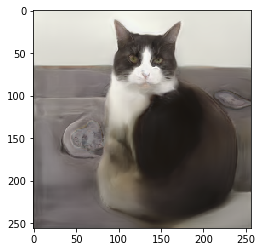

< 가장 높은 확률을 가지는 클래스들 >
인덱스: 284 / 클래스명: Siamese cat, Siamese / 확률: 8.9444%
인덱스: 281 / 클래스명: tabby, tabby cat / 확률: 8.5205%
인덱스: 285 / 클래스명: Egyptian cat / 확률: 5.8957%
[ i = 340 ]
[ 현재 이미지 ]


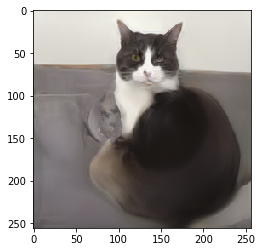

< 가장 높은 확률을 가지는 클래스들 >
인덱스: 673 / 클래스명: mouse, computer mouse / 확률: 10.557%
인덱스: 722 / 클래스명: ping-pong ball / 확률: 8.507%
인덱스: 428 / 클래스명: barrow, garden cart, lawn cart, wheelbarrow / 확률: 6.8501%
[ i = 360 ]
[ 현재 이미지 ]


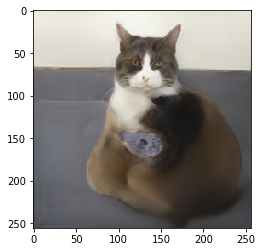

< 가장 높은 확률을 가지는 클래스들 >
인덱스: 281 / 클래스명: tabby, tabby cat / 확률: 34.3712%
인덱스: 285 / 클래스명: Egyptian cat / 확률: 25.1561%
인덱스: 284 / 클래스명: Siamese cat, Siamese / 확률: 16.0331%
[ i = 380 ]
[ 현재 이미지 ]


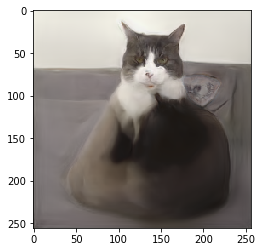

< 가장 높은 확률을 가지는 클래스들 >
인덱스: 281 / 클래스명: tabby, tabby cat / 확률: 47.6834%
인덱스: 428 / 클래스명: barrow, garden cart, lawn cart, wheelbarrow / 확률: 14.0931%
인덱스: 282 / 클래스명: tiger cat / 확률: 12.6677%
[ i = 400 ]
[ 현재 이미지 ]


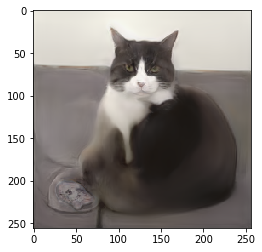

< 가장 높은 확률을 가지는 클래스들 >
인덱스: 284 / 클래스명: Siamese cat, Siamese / 확률: 62.3281%
인덱스: 281 / 클래스명: tabby, tabby cat / 확률: 10.7777%
인덱스: 673 / 클래스명: mouse, computer mouse / 확률: 7.4579%
[ i = 420 ]
[ 현재 이미지 ]


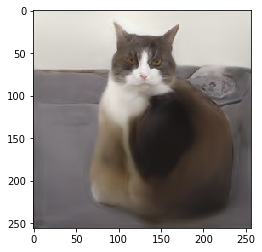

< 가장 높은 확률을 가지는 클래스들 >
인덱스: 940 / 클래스명: spaghetti squash / 확률: 13.7425%
인덱스: 428 / 클래스명: barrow, garden cart, lawn cart, wheelbarrow / 확률: 13.237%
인덱스: 673 / 클래스명: mouse, computer mouse / 확률: 6.3433%
[ i = 440 ]
[ 현재 이미지 ]


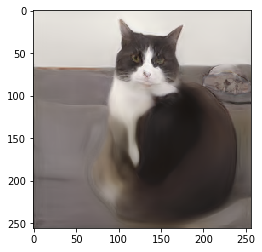

< 가장 높은 확률을 가지는 클래스들 >
인덱스: 478 / 클래스명: carton / 확률: 17.1181%
인덱스: 673 / 클래스명: mouse, computer mouse / 확률: 11.4465%
인덱스: 285 / 클래스명: Egyptian cat / 확률: 5.7437%
[ i = 460 ]
[ 현재 이미지 ]


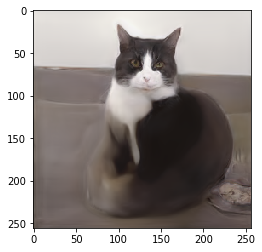

< 가장 높은 확률을 가지는 클래스들 >
인덱스: 285 / 클래스명: Egyptian cat / 확률: 37.6525%
인덱스: 478 / 클래스명: carton / 확률: 11.6407%
인덱스: 281 / 클래스명: tabby, tabby cat / 확률: 9.2519%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ i = 480 ]
[ 현재 이미지 ]


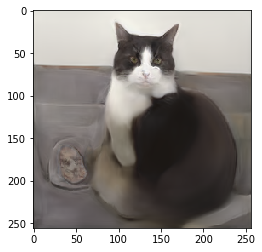

< 가장 높은 확률을 가지는 클래스들 >
인덱스: 285 / 클래스명: Egyptian cat / 확률: 17.1927%
인덱스: 284 / 클래스명: Siamese cat, Siamese / 확률: 9.1549%
인덱스: 281 / 클래스명: tabby, tabby cat / 확률: 8.3759%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ i = 500 ]
[ 현재 이미지 ]


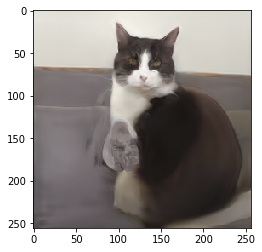

< 가장 높은 확률을 가지는 클래스들 >
인덱스: 285 / 클래스명: Egyptian cat / 확률: 21.2817%
인덱스: 728 / 클래스명: plastic bag / 확률: 11.0425%
인덱스: 666 / 클래스명: mortar / 확률: 7.3735%
[ i = 520 ]
[ 현재 이미지 ]


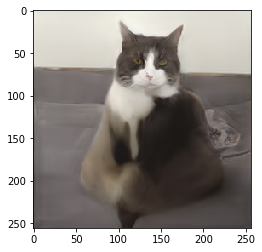

< 가장 높은 확률을 가지는 클래스들 >
인덱스: 285 / 클래스명: Egyptian cat / 확률: 49.5399%
인덱스: 284 / 클래스명: Siamese cat, Siamese / 확률: 16.48%
인덱스: 478 / 클래스명: carton / 확률: 8.5373%
[ i = 540 ]
[ 현재 이미지 ]


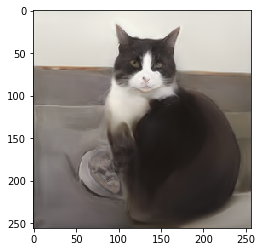

< 가장 높은 확률을 가지는 클래스들 >
인덱스: 285 / 클래스명: Egyptian cat / 확률: 7.8212%
인덱스: 859 / 클래스명: toaster / 확률: 7.0249%
인덱스: 478 / 클래스명: carton / 확률: 5.0638%
[ i = 560 ]
[ 현재 이미지 ]


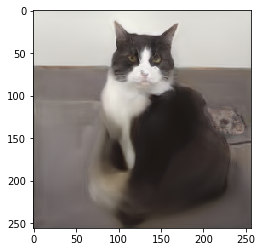

< 가장 높은 확률을 가지는 클래스들 >
인덱스: 285 / 클래스명: Egyptian cat / 확률: 41.9826%
인덱스: 281 / 클래스명: tabby, tabby cat / 확률: 6.8013%
인덱스: 478 / 클래스명: carton / 확률: 6.4854%
[ i = 580 ]
[ 현재 이미지 ]


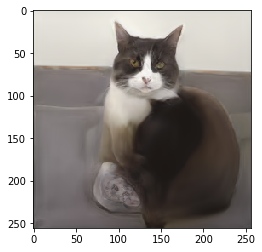

< 가장 높은 확률을 가지는 클래스들 >
인덱스: 285 / 클래스명: Egyptian cat / 확률: 42.6914%
인덱스: 287 / 클래스명: lynx, catamount / 확률: 8.5405%
인덱스: 478 / 클래스명: carton / 확률: 6.651%
[ i = 600 ]
[ 현재 이미지 ]


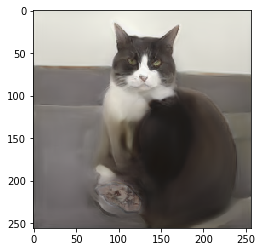

< 가장 높은 확률을 가지는 클래스들 >
인덱스: 478 / 클래스명: carton / 확률: 65.6539%
인덱스: 940 / 클래스명: spaghetti squash / 확률: 3.2409%
인덱스: 285 / 클래스명: Egyptian cat / 확률: 1.9021%
[ i = 620 ]
[ 현재 이미지 ]


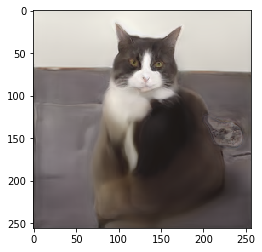

< 가장 높은 확률을 가지는 클래스들 >
인덱스: 478 / 클래스명: carton / 확률: 18.46%
인덱스: 285 / 클래스명: Egyptian cat / 확률: 15.1954%
인덱스: 281 / 클래스명: tabby, tabby cat / 확률: 4.6343%
[ i = 640 ]
[ 현재 이미지 ]


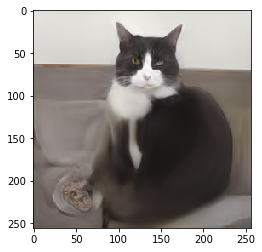

< 가장 높은 확률을 가지는 클래스들 >
인덱스: 285 / 클래스명: Egyptian cat / 확률: 11.3357%
인덱스: 281 / 클래스명: tabby, tabby cat / 확률: 11.0797%
인덱스: 722 / 클래스명: ping-pong ball / 확률: 9.6993%
[ i = 660 ]
[ 현재 이미지 ]


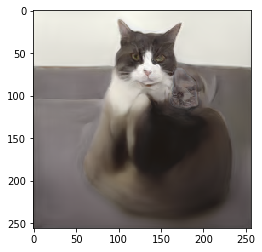

< 가장 높은 확률을 가지는 클래스들 >
인덱스: 666 / 클래스명: mortar / 확률: 48.3407%
인덱스: 281 / 클래스명: tabby, tabby cat / 확률: 21.2174%
인덱스: 285 / 클래스명: Egyptian cat / 확률: 8.6382%
[ i = 680 ]
[ 현재 이미지 ]


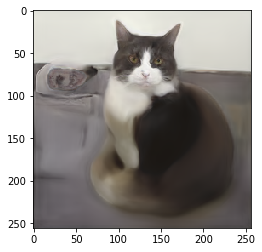

< 가장 높은 확률을 가지는 클래스들 >
인덱스: 673 / 클래스명: mouse, computer mouse / 확률: 26.0427%
인덱스: 285 / 클래스명: Egyptian cat / 확률: 22.1336%
인덱스: 281 / 클래스명: tabby, tabby cat / 확률: 5.3221%
[ i = 700 ]
[ 현재 이미지 ]


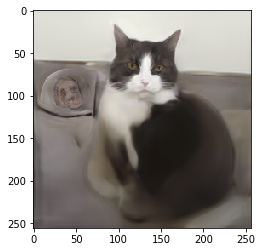

< 가장 높은 확률을 가지는 클래스들 >
인덱스: 281 / 클래스명: tabby, tabby cat / 확률: 13.8994%
인덱스: 673 / 클래스명: mouse, computer mouse / 확률: 11.9187%
인덱스: 282 / 클래스명: tiger cat / 확률: 10.9923%
[ i = 720 ]
[ 현재 이미지 ]


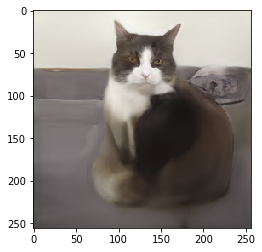

< 가장 높은 확률을 가지는 클래스들 >
인덱스: 285 / 클래스명: Egyptian cat / 확률: 29.2813%
인덱스: 281 / 클래스명: tabby, tabby cat / 확률: 12.4038%
인덱스: 284 / 클래스명: Siamese cat, Siamese / 확률: 12.3813%
[ i = 740 ]
[ 현재 이미지 ]


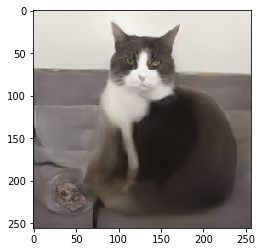

< 가장 높은 확률을 가지는 클래스들 >
인덱스: 940 / 클래스명: spaghetti squash / 확률: 34.2816%
인덱스: 837 / 클래스명: sunglasses, dark glasses, shades / 확률: 6.3064%
인덱스: 941 / 클래스명: acorn squash / 확률: 3.5269%
[ i = 760 ]
[ 현재 이미지 ]


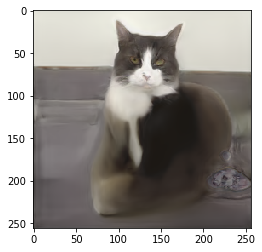

< 가장 높은 확률을 가지는 클래스들 >
인덱스: 435 / 클래스명: bathtub, bathing tub, bath, tub / 확률: 25.8385%
인덱스: 285 / 클래스명: Egyptian cat / 확률: 17.4428%
인덱스: 281 / 클래스명: tabby, tabby cat / 확률: 5.2176%
[ i = 780 ]
[ 현재 이미지 ]


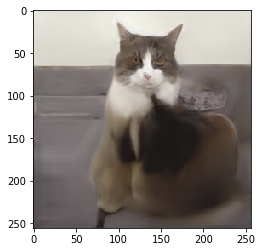

< 가장 높은 확률을 가지는 클래스들 >
인덱스: 281 / 클래스명: tabby, tabby cat / 확률: 21.9506%
인덱스: 284 / 클래스명: Siamese cat, Siamese / 확률: 17.8403%
인덱스: 285 / 클래스명: Egyptian cat / 확률: 11.9779%
[ i = 800 ]
[ 현재 이미지 ]


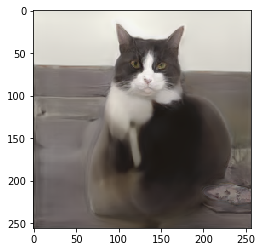

< 가장 높은 확률을 가지는 클래스들 >
인덱스: 435 / 클래스명: bathtub, bathing tub, bath, tub / 확률: 12.1971%
인덱스: 940 / 클래스명: spaghetti squash / 확률: 6.8563%
인덱스: 285 / 클래스명: Egyptian cat / 확률: 6.3592%
[ i = 820 ]
[ 현재 이미지 ]


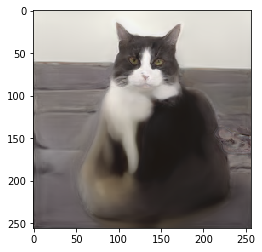

< 가장 높은 확률을 가지는 클래스들 >
인덱스: 281 / 클래스명: tabby, tabby cat / 확률: 18.7662%
인덱스: 285 / 클래스명: Egyptian cat / 확률: 13.7001%
인덱스: 539 / 클래스명: doormat, welcome mat / 확률: 7.7077%
[ i = 840 ]
[ 현재 이미지 ]


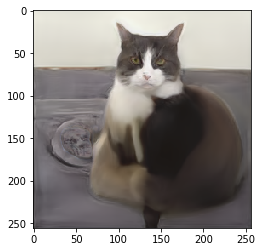

< 가장 높은 확률을 가지는 클래스들 >
인덱스: 722 / 클래스명: ping-pong ball / 확률: 36.1643%
인덱스: 285 / 클래스명: Egyptian cat / 확률: 9.4111%
인덱스: 673 / 클래스명: mouse, computer mouse / 확률: 8.7935%
[ i = 860 ]
[ 현재 이미지 ]


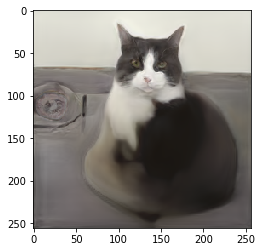

< 가장 높은 확률을 가지는 클래스들 >
인덱스: 673 / 클래스명: mouse, computer mouse / 확률: 16.7667%
인덱스: 285 / 클래스명: Egyptian cat / 확률: 10.3333%
인덱스: 281 / 클래스명: tabby, tabby cat / 확률: 7.8379%
[ i = 880 ]
[ 현재 이미지 ]


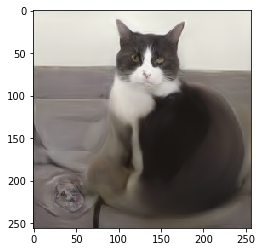

< 가장 높은 확률을 가지는 클래스들 >
인덱스: 285 / 클래스명: Egyptian cat / 확률: 51.6203%
인덱스: 281 / 클래스명: tabby, tabby cat / 확률: 7.702%
인덱스: 284 / 클래스명: Siamese cat, Siamese / 확률: 6.4461%
[ i = 900 ]
[ 현재 이미지 ]


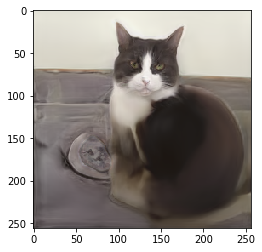

< 가장 높은 확률을 가지는 클래스들 >
인덱스: 897 / 클래스명: washer, automatic washer, washing machine / 확률: 37.626%
인덱스: 412 / 클래스명: ashcan, trash can, garbage can, wastebin, ash bin, ash-bin, ashbin, dustbin, trash barrel, trash bin / 확률: 5.1391%
인덱스: 478 / 클래스명: carton / 확률: 3.7831%
[ i = 920 ]
[ 현재 이미지 ]


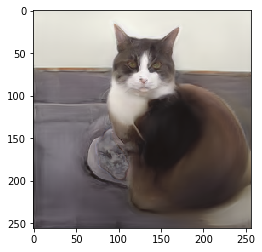

< 가장 높은 확률을 가지는 클래스들 >
인덱스: 338 / 클래스명: guinea pig, Cavia cobaya / 확률: 49.3643%
인덱스: 285 / 클래스명: Egyptian cat / 확률: 14.1845%
인덱스: 281 / 클래스명: tabby, tabby cat / 확률: 3.9162%
[ i = 940 ]
[ 현재 이미지 ]


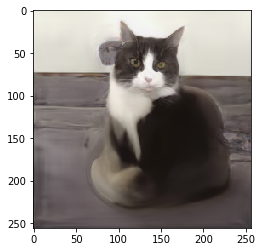

< 가장 높은 확률을 가지는 클래스들 >
인덱스: 435 / 클래스명: bathtub, bathing tub, bath, tub / 확률: 9.6634%
인덱스: 876 / 클래스명: tub, vat / 확률: 7.2032%
인덱스: 896 / 클래스명: washbasin, handbasin, washbowl, lavabo, wash-hand basin / 확률: 4.9114%
[ i = 960 ]
[ 현재 이미지 ]


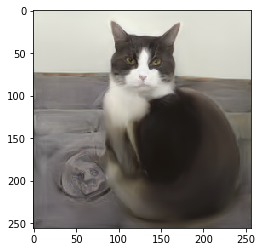

< 가장 높은 확률을 가지는 클래스들 >
인덱스: 940 / 클래스명: spaghetti squash / 확률: 31.6263%
인덱스: 428 / 클래스명: barrow, garden cart, lawn cart, wheelbarrow / 확률: 7.5232%
인덱스: 673 / 클래스명: mouse, computer mouse / 확률: 7.29%
[ i = 980 ]
[ 현재 이미지 ]


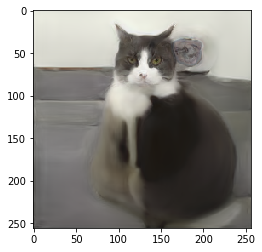

< 가장 높은 확률을 가지는 클래스들 >
인덱스: 478 / 클래스명: carton / 확률: 11.9255%
인덱스: 435 / 클래스명: bathtub, bathing tub, bath, tub / 확률: 11.213%
인덱스: 940 / 클래스명: spaghetti squash / 확률: 8.0166%


In [22]:
# 공격용 파라미터 설정
eps = 8/255
alpha = 0.5/255
iters = 1000

# 얼룩 고양이(tabby cat)으로 보이도록 설정
ori_label = "tabby cat" # index: 281

# 까치(magpie)로 분류되도록 공격 수행
trg_label = [18]
trg_label = torch.Tensor(trg_label)
trg_label = trg_label.type(torch.long)

latent, perturbation,attack_success_list = unrestricted_attack(generator, classifier, ori_label, trg_label, eps, alpha, iters)

In [23]:
attack_success_list

[]

In [24]:
len(attack_success_list)

0